### Assignment 1

Submission should be in a Jupyter note book (.ipynb)

1. Implement a function that converts a ```fixed<w, b>``` representation to a real number. Use two's compement for negative numbers. The function signature is 

   ```python
   def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
   # w: width of the binary representation
   # b: binary point
   ```
   Test the following inputs
   ```python
   fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])
   ```
   ```python
   fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])
   ```
   ```python
   fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])
   ```
   


In [1]:
def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
    sum=-bits[0]*2**(w-1-b)
    bits.reverse()
    bits=bits[0:len(bits)-1]
    for i in range(0,len(bits)):
     sum+=bits[i]*2**(i-b)
    
    
    return sum

In [2]:
fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])

44.75

In [3]:
fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])

-13.28125

In [4]:
fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])

-21.25

2. Calculate the price of the following questions step by step using two step Cox Rox Rubinstein (CRR) Binomial tree

    a. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    b. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    c. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    d. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    What is the value of the portfolio that is long (a) and short (b)? How about the portfolio that long (c) and short (d)?
    

In [5]:
from enum import Enum
import math

In [6]:
import numpy as np


In [7]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'

In [8]:
def crrBinomial(S, r, vol, payoffType, K, T, n):
    t = T / n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # set up the last time slice, there are n+1 nodes at the last time slice
    payoffDict = {
        PayoffType.Call: lambda s: max(s-K, 0),
        PayoffType.Put: lambda s: max(K-s, 0),
    }
    vs = [payoffDict[payoffType]( S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            vs[j] = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
    return vs[0]

In [9]:
print("crrNStepTree: \t", crrBinomial(100, 0.03, 0.2, PayoffType.Call, 105, 1, 2))

crrNStepTree: 	 7.334893644625005


In [10]:
print("crrNStepTree: \t", crrBinomial(100, 0.03, 0.2, PayoffType.Put, 105, 1, 2))

crrNStepTree: 	 9.231674667218368


In [11]:
print("Portfolio Value: \t",(crrBinomial(100, 0.03, 0.2, PayoffType.Call, 105, 1, 2)-crrBinomial(100, 0.03, 0.2, PayoffType.Put, 105, 1, 2)))

Portfolio Value: 	 -1.8967810225933626


In [12]:
print("crrNStepTree: \t", crrBinomial(100, 0.03, 0.1, PayoffType.Call, 105, 1, 2))

crrNStepTree: 	 3.555283800757024


In [13]:
print("crrNStepTree: \t", crrBinomial(100, 0.03, 0.1, PayoffType.Put, 105, 1, 2))

crrNStepTree: 	 5.452064823350394


In [14]:
print("Portfolio Value: \t",(crrBinomial(100, 0.03, 0.1, PayoffType.Call, 105, 1, 2)-crrBinomial(100, 0.03, 0.1, PayoffType.Put, 105, 1, 2)))

Portfolio Value: 	 -1.8967810225933701


3. Greeks measure the sensitivity of the price of derivatives to a change in underlying asset’s parameters. They are used for hedging and risk
management. The commonly used greeks are:
    * Delta $\Delta = \frac{\partial V}{\partial S}$: measures the rate of change of the option value with respect to changes in the underlying asset's price.
    * Gamma $\Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S}$: measures the rate of change of delta with respect to changes in the underlying asset's price.
    * Vega: $v = \frac{\partial V}{\partial \sigma}$: measures the rate of change of the option value with respect to changes in the underlying asset's volatility.
    * Theta: $\theta = \frac{\partial V}{\partial t}$: the rate of change in the price of an option with respect to pricing time. Note that we normally use $t$ to represent pricing time, $T$ to represent expiry time, time to expiry in our pricer is $T-t$. In the implementation of the pricers that take time to expiry as an argument, we implicitly set pricing time to 0 (present).
    * Rho (PV01): the rate of change in the price of an option in response to a change in the interest rate.
    
  The greeks are normally not known in closed form since numerical pricers are used. They are approximated by finite differences:

    \begin{align}
    & \Delta = \frac{\partial V}{\partial S} \approx \frac{V(S + \Delta S) - V(S-\Delta S)}{2 \Delta S}, ~~~\Delta S = 0.1\% S \\
    & \Gamma = \frac{\partial V^2}{\partial S^2} \approx \frac{V(S + \Delta S) - 2V(S) + V(S-\Delta S)}{\Delta S^2} \\
    & v = \frac{\partial V}{\partial \sigma} \approx \frac{V(S, \sigma +\Delta \sigma) - V(S, \sigma -\Delta \sigma)}{2 \Delta \sigma } ~~~~~~~\Delta \sigma = 0.1\% \\
    & \theta = \frac{\partial V}{\partial t} \approx \frac{V(S, t+\Delta t, T) - V(S, t, T)}{\Delta t} ~~~~\Delta t = 0.004 \\
    & \text{PV01} = \frac{\partial V}{\partial r} \approx \frac{V(S, r+\Delta r) - V(S, r - \Delta r)}{2 \Delta r}  ~~~~~\Delta r = 0.0001
    \end{align}

  Implement a Greeks calculater for binomial tree pricer provided below. The signature of the greeks calculator is
      ```python
      def binomialGreeks(S, r, vol, T, strike, greekType) -> float
      ```
  Setting $S = 100, r = 0.03, vol = 0.2, t = 0, T = 1$, plot each greeks as a function of strike from 50 to 150. Play with different binomial models and see if there is any difference.
  
  Note that in practice, the greeks are rescaled with a pre-defined scaler, so that they give a sense of how much PV (Delta) changes with a typical move of the market. The rescaling is not incorporated in this exercise.

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [16]:
# binomial pricer for exercise 3
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

# Rough Work

In [17]:
binomialPricer(100,0.01,0.2,EuropeanOption(1, 105, PayoffType.Call),1000,jrrnCalib)

6.298775527970587

In [18]:
V_100=[binomialPricer(100,0.03,0.2,AmericanOption(1, i, PayoffType.Call),100,crrCalib) for i in range(50,151)]

In [19]:
V_L=[binomialPricer(100*0.999,0.03,0.2,AmericanOption(1, i, PayoffType.Call),100,crrCalib) for i in range(50,151)]

In [20]:
V_U=[binomialPricer(100*1.001,0.03,0.2,AmericanOption(1, i, PayoffType.Call),100,crrCalib) for i in range(50,151)]

In [21]:
delta=(np.array(V_U)-np.array(V_L))/(2*100*0.001)

In [22]:
gamma=(np.array(V_U)+np.array(V_L)-2*np.array(V_100))/(100**2*0.001)

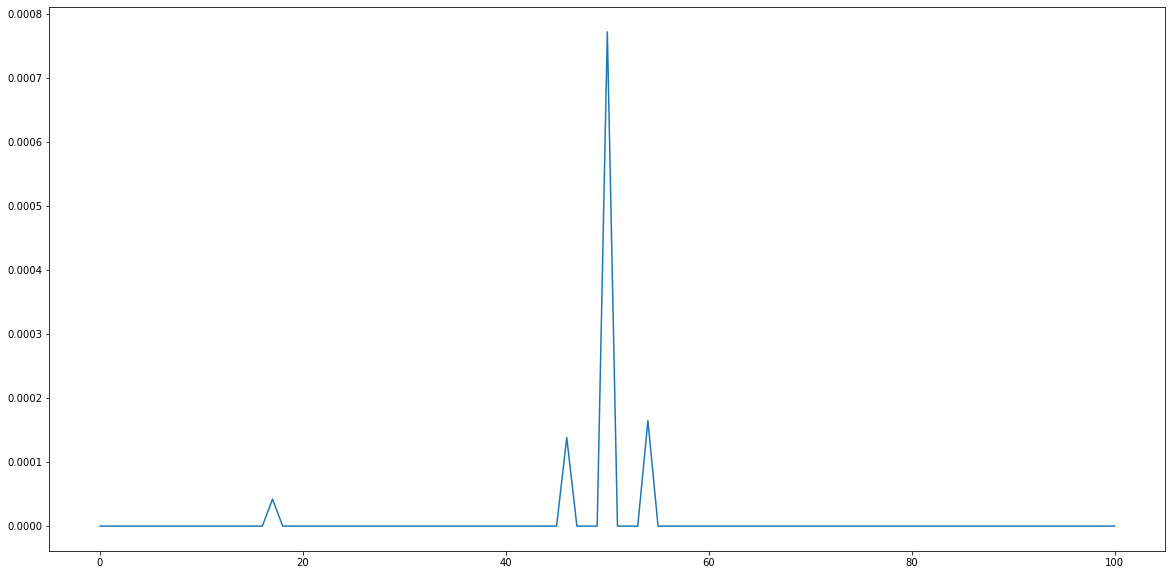

In [23]:
plt.plot(gamma)

In [24]:
V_SL=[binomialPricer(100,0.03,0.2*0.999,AmericanOption(1, i, PayoffType.Call),100,jrrnCalib) for i in range(50,151)]

In [25]:
V_SU=[binomialPricer(100,0.03,0.2*1.001,AmericanOption(1, i, PayoffType.Call),100,jrrnCalib) for i in range(50,151)]

In [26]:
vega=(np.array(V_SU)-np.array(V_SL))/(2*0.2*0.001)

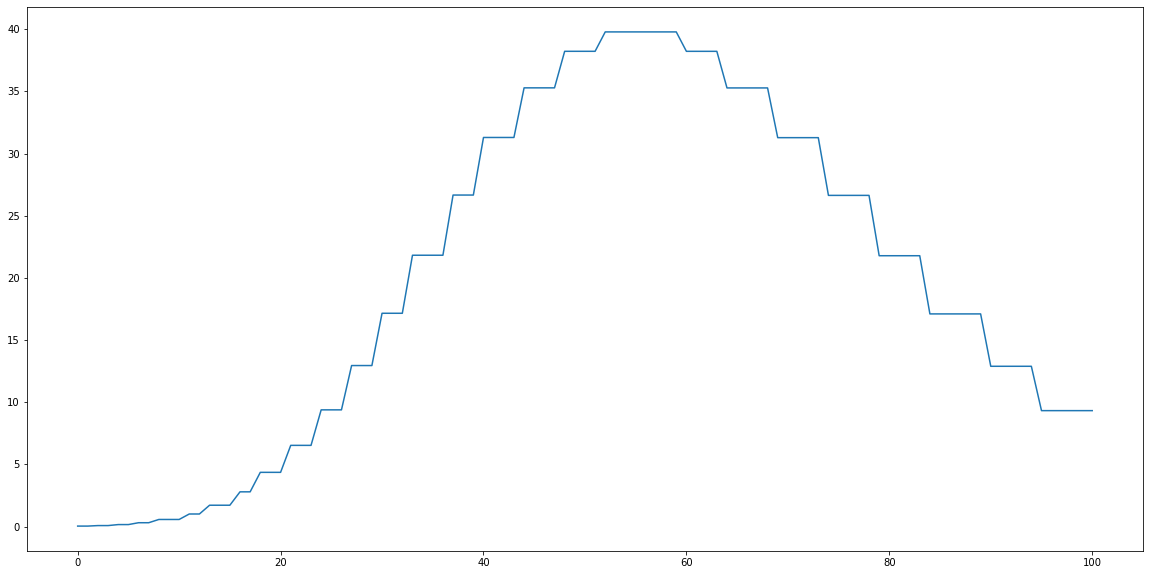

In [27]:
plt.plot(vega)

In [28]:
V_TU=[binomialPricer(100,0.03,0.2,AmericanOption(1-0.004, i, PayoffType.Call),100,jrrnCalib) for i in range(50,151)]

In [29]:
theta=(np.array(V_TU)-np.array(V_100))/(0.004)

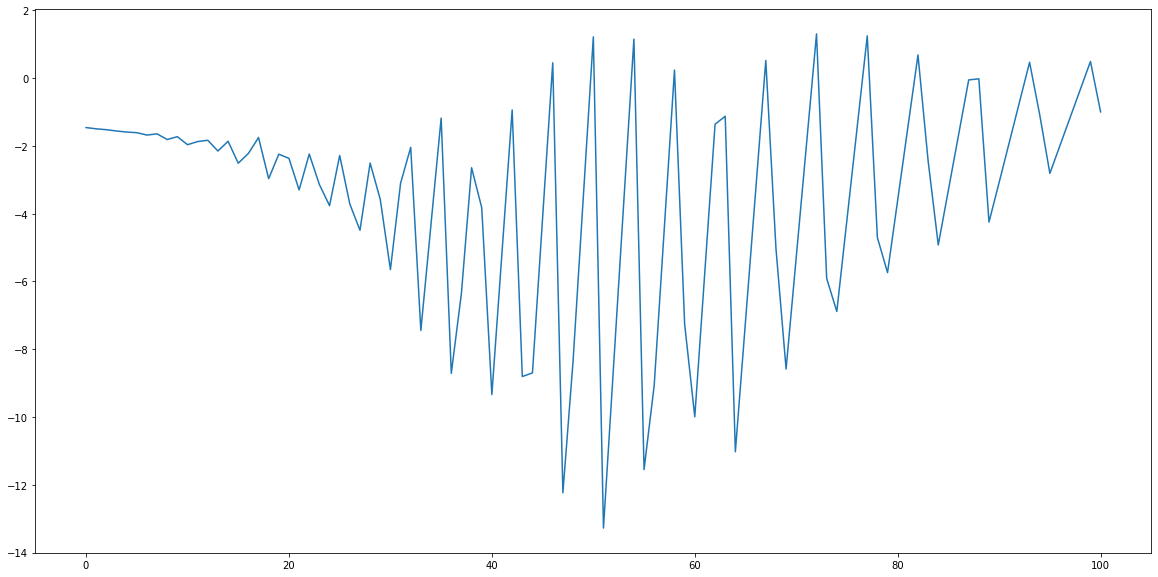

In [30]:
plt.plot(theta)

In [31]:
V_RU=[binomialPricer(100,0.03+0.0001,0.2,EuropeanOption(1, i, PayoffType.Call),1000,jrrnCalib) for i in range(50,151)]

In [32]:
V_RL=[binomialPricer(100,0.03-0.0001,0.2,EuropeanOption(1, i, PayoffType.Call),1000,jrrnCalib) for i in range(50,151)]

In [33]:
PV=(np.array(V_RU)-np.array(V_RL))/(2*0.0001)

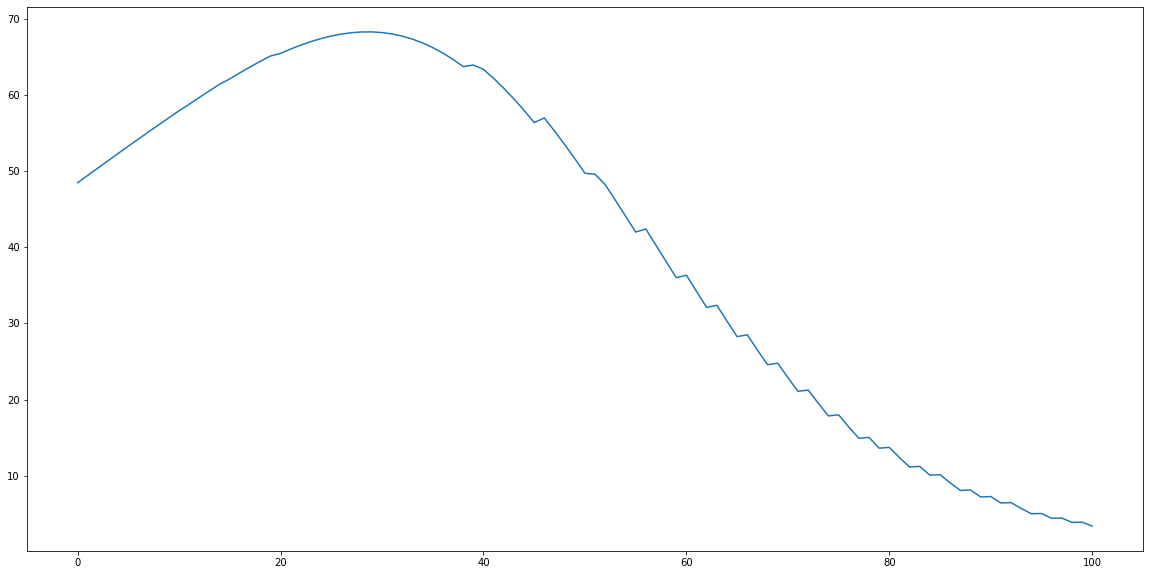

In [34]:
plt.plot(PV)

# Main Function with crrCalib

In [35]:
def binomialGreeks(S, r, vol, T, strike, greekType) -> float:
    V=binomialPricer(S,r,vol,AmericanOption(T, strike, PayoffType.Call),100,crrCalib)
    if greekType=="Delta":
        V_DL=binomialPricer(S*0.999,r,vol,AmericanOption(T, strike, PayoffType.Call),100,crrCalib) 
        V_DU=binomialPricer(S*1.001,r,vol,AmericanOption(T, strike, PayoffType.Call),100,crrCalib)
        Delta=(np.array(V_DU)-np.array(V_DL))/(2*S*0.001)
        return Delta
    if greekType=="Vega":
        V_VL=binomialPricer(S,r,vol*0.999,AmericanOption(T, strike, PayoffType.Call),100,crrCalib) 
        V_VU=binomialPricer(S,r,vol*1.001,AmericanOption(T, strike, PayoffType.Call),100,crrCalib)
        Vega=(np.array(V_VU)-np.array(V_VL))/(2*vol*0.001)
        return Vega
    if greekType=="Gamma":
        V_GL=binomialPricer(S*0.999,r,vol,AmericanOption(T, strike, PayoffType.Call),100,crrCalib) 
        V_GU=binomialPricer(S*1.001,r,vol,AmericanOption(T, strike, PayoffType.Call),100,crrCalib)
        Gamma=(np.array(V_GU)+np.array(V_GL)-2*np.array(V))/(S*0.001)**2
        return Gamma
    if greekType=="Theta":
        V_TU=binomialPricer(S,r,vol,AmericanOption(T-0.004, strike, PayoffType.Call),100,crrCalib)
        Theta=(np.array(V_TU)-np.array(V))/(0.004)
        return Theta
    if greekType=="PV":
        V_PL=binomialPricer(S,r-0.0001,vol,AmericanOption(T, strike, PayoffType.Call),100,crrCalib) 
        V_PU=binomialPricer(S,r+0.0001,vol,AmericanOption(T, strike, PayoffType.Call),100,crrCalib)
        PV=(np.array(V_PU)-np.array(V_PL))/(2*0.0001)
        return PV
        
        
        
    
        

In [36]:
Deltas=[binomialGreeks(100,0.03,0.2,1,i,"Delta") for i in range(50,151)]

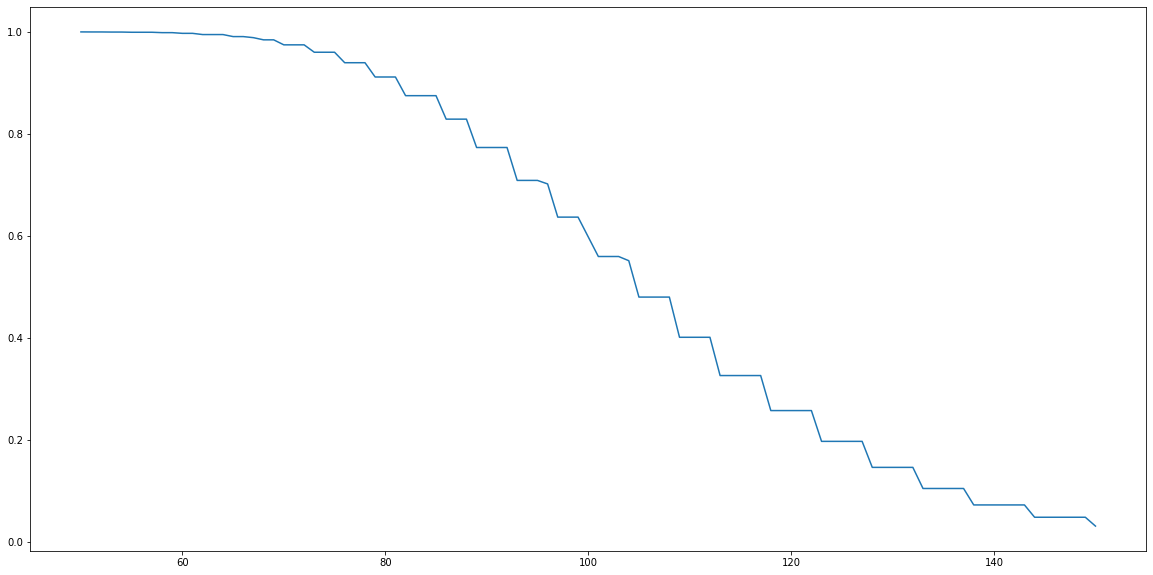

In [37]:
plt.plot(range(50,151),Deltas)

In [38]:
def plotter(greekType):
    greeks=[binomialGreeks(100,0.03,0.2,1,i,greekType) for i in range(50,151)]
    plt.plot(range(50,151),greeks)

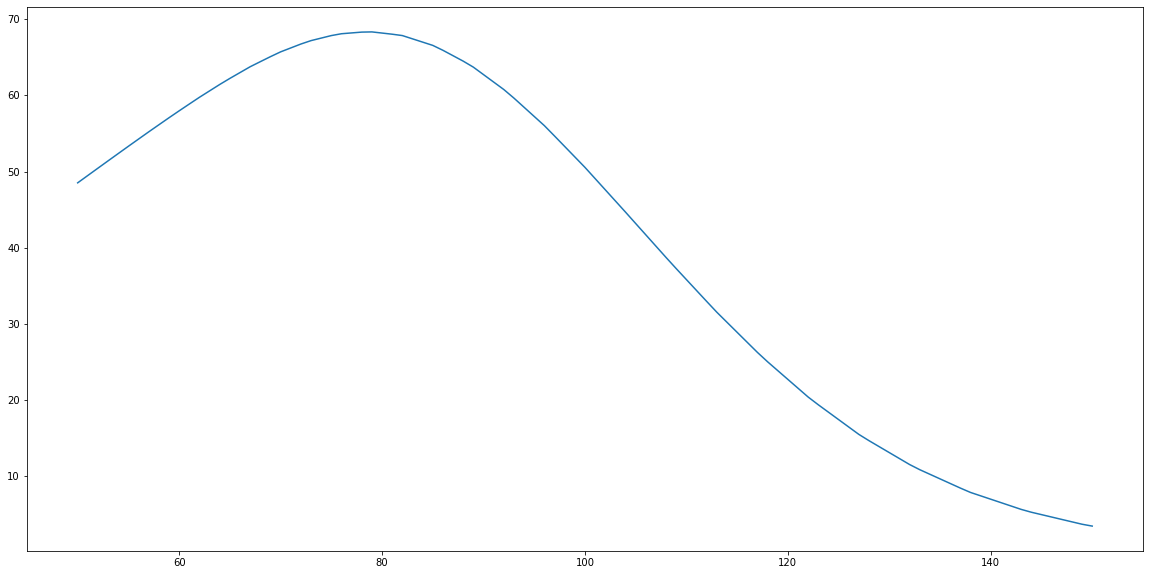

In [39]:
plotter("PV")

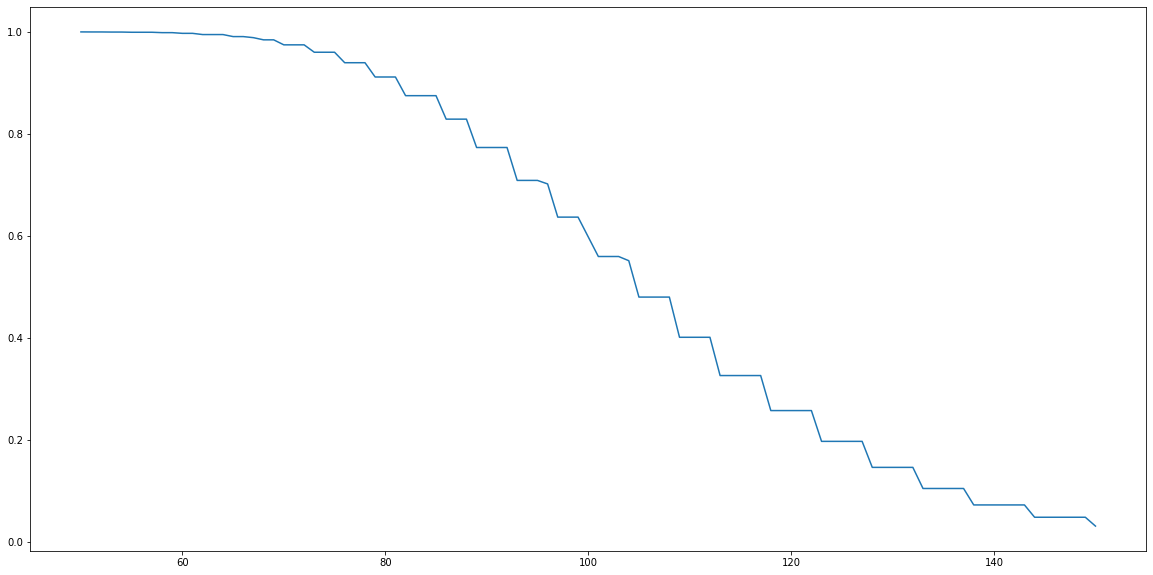

In [40]:
plotter("Delta")

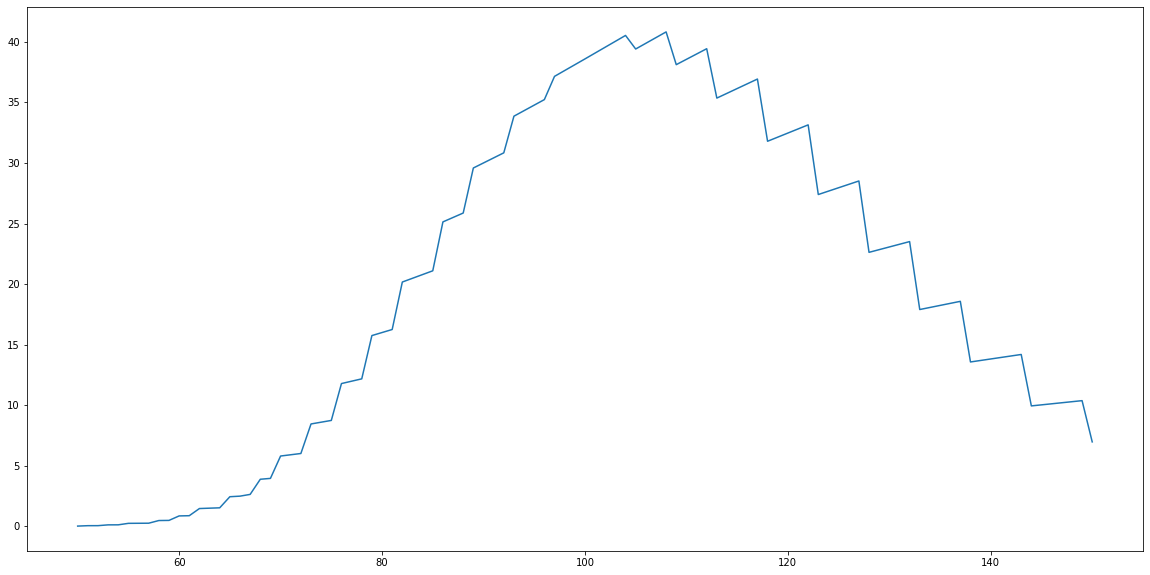

In [41]:
plotter("Vega")

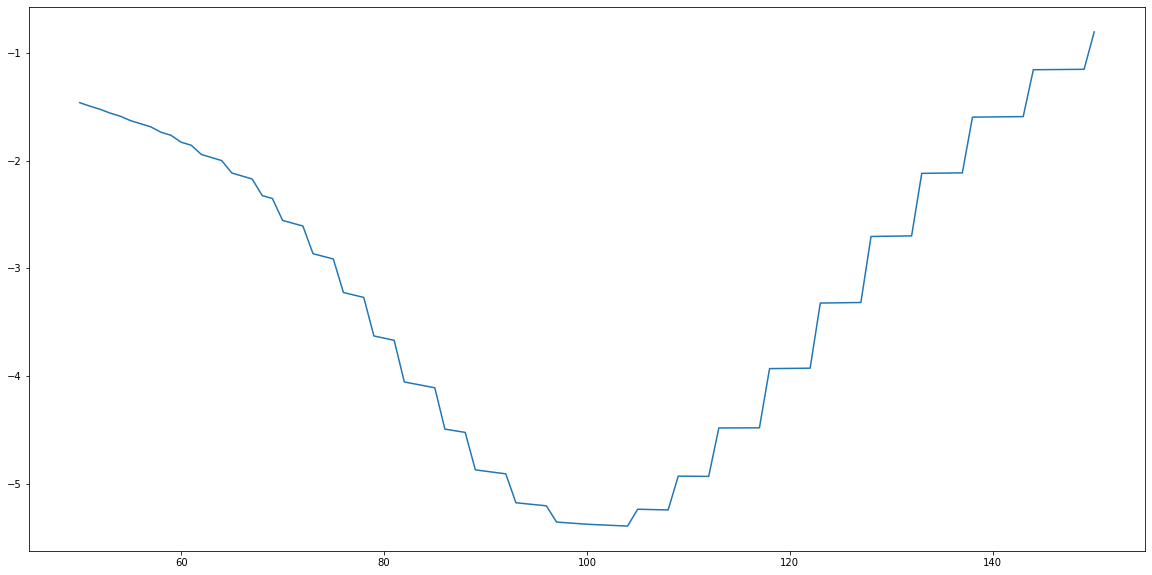

In [42]:
plotter("Theta")

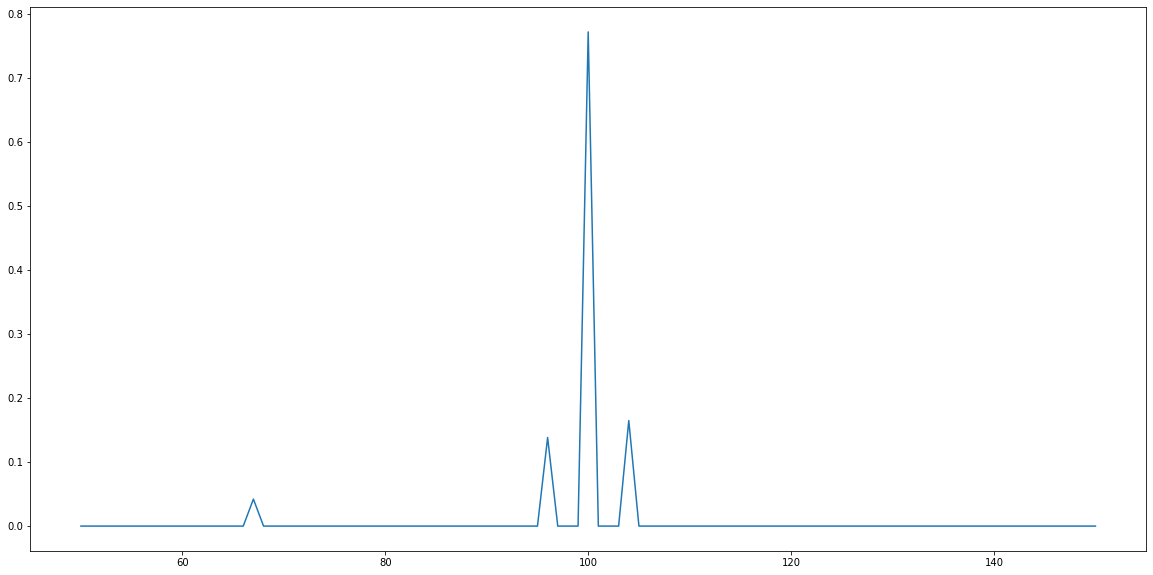

In [43]:
plotter("Gamma")

# Using Different Pricers

In [44]:
def binomialGreeks2(S, r, vol, T, strike, greekType,calib) -> float:
    V=binomialPricer(S,r,vol,AmericanOption(T, strike, PayoffType.Call),100,calib)
    if greekType=="Delta":
        V_DL=binomialPricer(S*0.999,r,vol,AmericanOption(T, strike, PayoffType.Call),100,calib) 
        V_DU=binomialPricer(S*1.001,r,vol,AmericanOption(T, strike, PayoffType.Call),100,calib)
        Delta=(np.array(V_DU)-np.array(V_DL))/(2*S*0.001)
        return Delta
    if greekType=="Vega":
        V_VL=binomialPricer(S,r,vol*0.999,AmericanOption(T, strike, PayoffType.Call),100,calib) 
        V_VU=binomialPricer(S,r,vol*1.001,AmericanOption(T, strike, PayoffType.Call),100,calib)
        Vega=(np.array(V_VU)-np.array(V_VL))/(2*vol*0.001)
        return Vega
    if greekType=="Gamma":
        V_GL=binomialPricer(S*0.999,r,vol,AmericanOption(T, strike, PayoffType.Call),100,calib) 
        V_GU=binomialPricer(S*1.001,r,vol,AmericanOption(T, strike, PayoffType.Call),100,calib)
        Gamma=(np.array(V_GU)+np.array(V_GL)-2*np.array(V))/(S*0.001)**2
        return Gamma
    if greekType=="Theta":
        V_TU=binomialPricer(S,r,vol,AmericanOption(T-0.004, strike, PayoffType.Call),100,calib)
        Theta=(np.array(V_TU)-np.array(V))/(0.004)
        return Theta
    if greekType=="PV":
        V_PL=binomialPricer(S,r-0.0001,vol,AmericanOption(T, strike, PayoffType.Call),100,calib) 
        V_PU=binomialPricer(S,r+0.0001,vol,AmericanOption(T, strike, PayoffType.Call),100,calib)
        PV=(np.array(V_PU)-np.array(V_PL))/(2*0.0001)
        return PV

In [45]:
def plotter2(greekType):
    greeksti=[binomialGreeks2(100,0.03,0.2,1,i,greekType,tianCalib) for i in range(50,151)]
    greeksjrr=[binomialGreeks2(100,0.03,0.2,1,i,greekType,jrrnCalib) for i in range(50,151)]
    greeksjreq=[binomialGreeks2(100,0.03,0.2,1,i,greekType,jreqCalib) for i in range(50,151)]


    
    plt.plot(range(50,151),greeksti,"r",label="Tian")   
    plt.plot(range(50,151),greeksjrr,"y--",label="Jrrn")
    plt.plot(range(50,151),greeksjreq,"b",label="Jreq")
    plt.legend()
    plt.show()
    

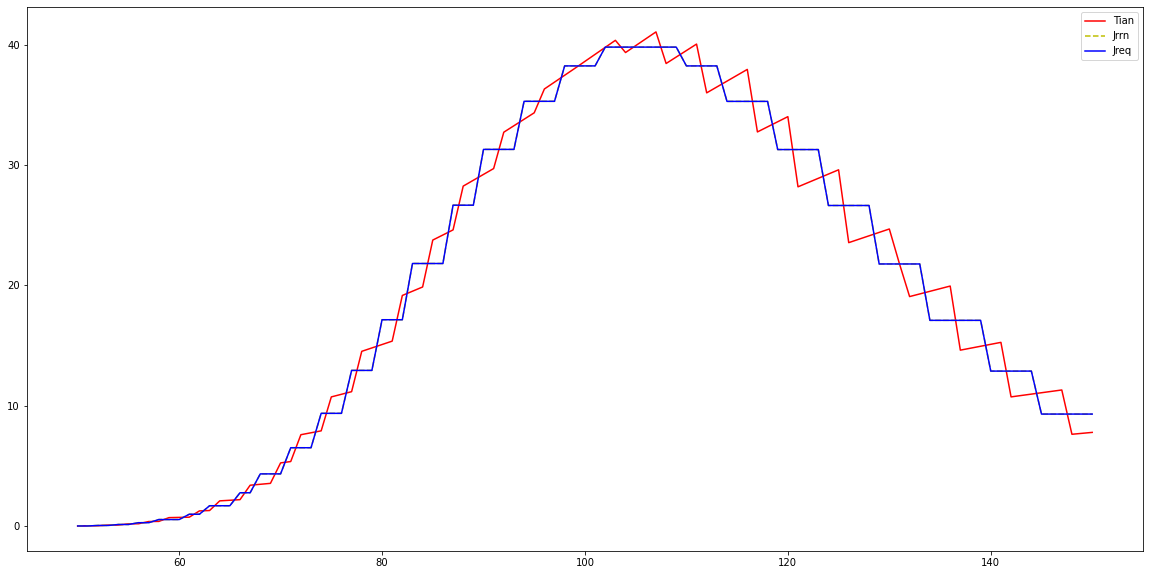

In [46]:
plotter2("Vega")

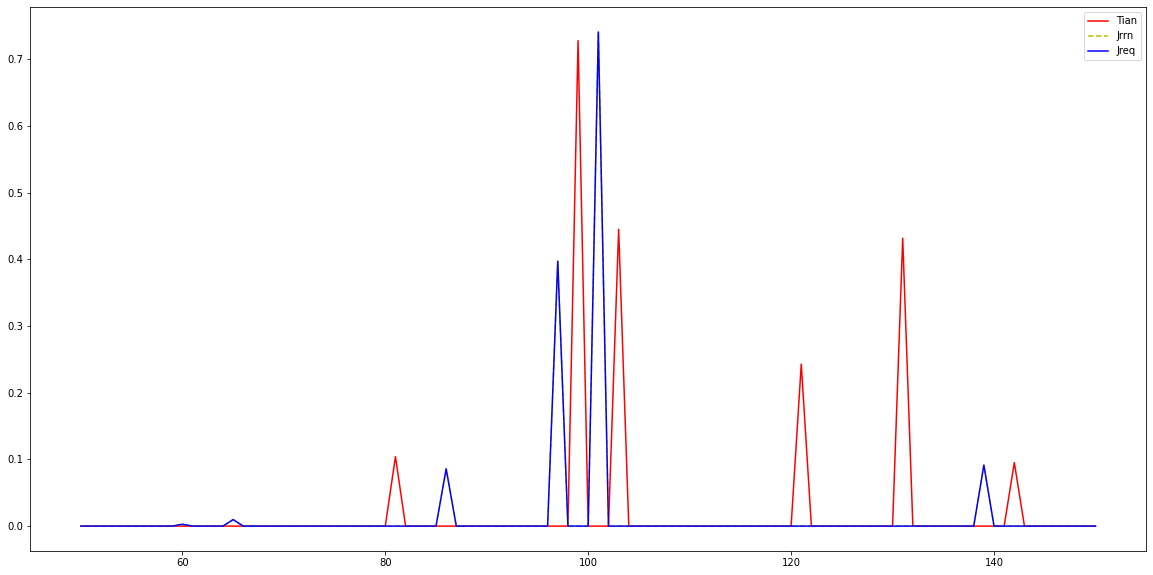

In [47]:
plotter2("Gamma")

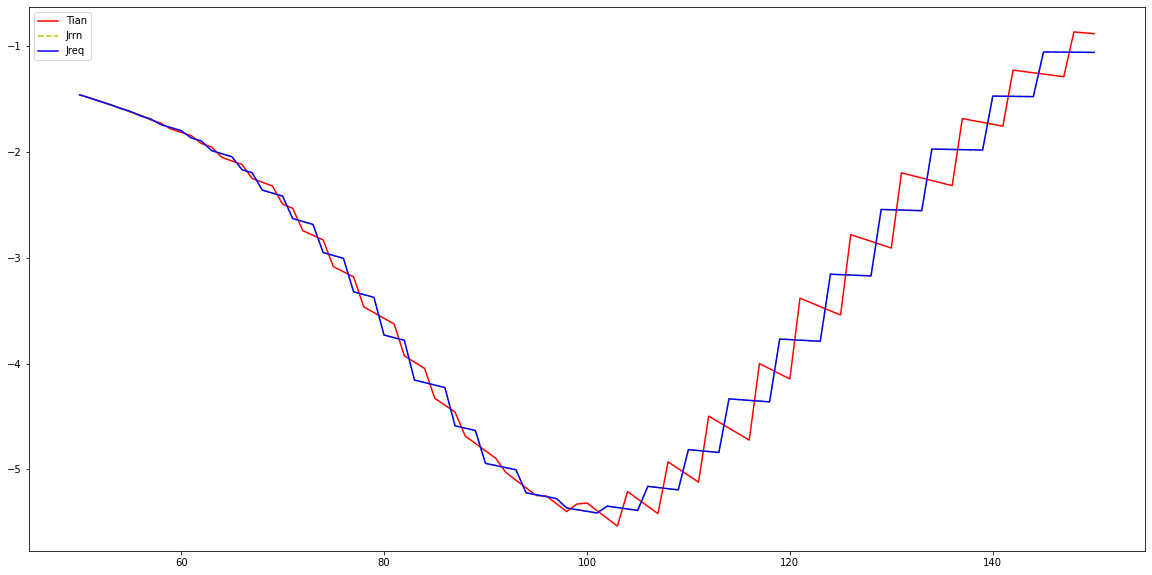

In [48]:
plotter2("Theta")

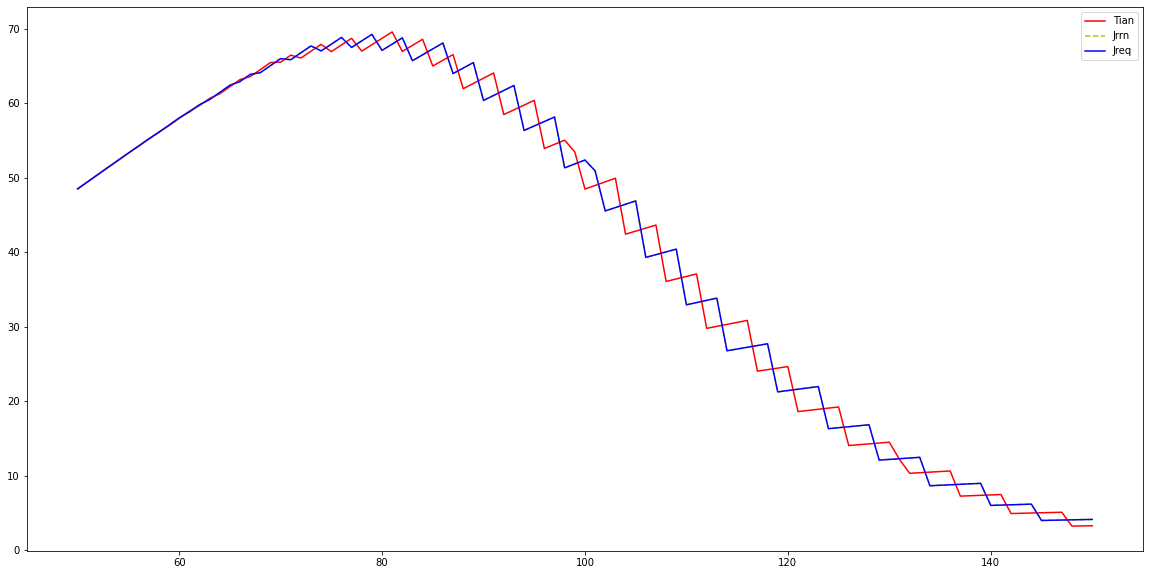

In [49]:
plotter2("PV")

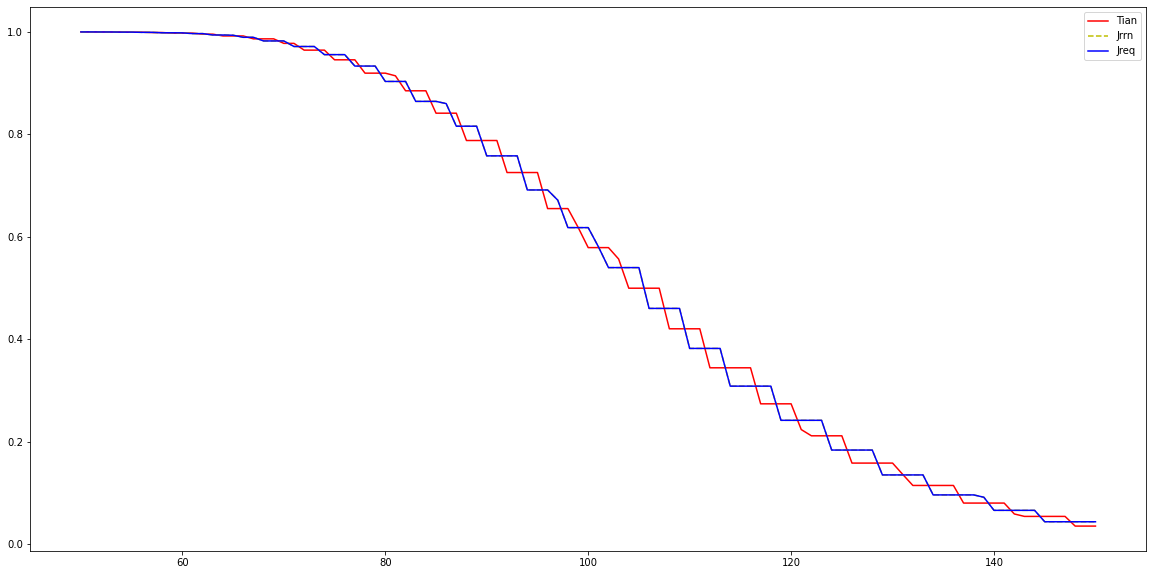

In [50]:
plotter2("Delta")

## Working with and without jreqCalib suggests that jrrnCalib and jreqCalib give the same greeks. 